In [1]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
import seis_test
import seis_invert
import seis_prior
#import seis_nn
import cupy as cp
import seis_diagnostics
import seis_forward2

maxcor
F:/seismic/models/brendan/*.pth
Loading:  F:/seismic/models/brendan\unet2d_caformer_seed3_epochbest.pt
n_models: 1


In [2]:
data=kgs.load_all_train_data()
d = data[8011]
print(d.family)

Style_A


In [3]:
# importlib.reload(seis_prior)
# importlib.reload(seis_diagnostics)
# importlib.reload(seis_invert)
# kgs.profiling=False
# kgs.debugging_mode = 0
# seis_forward2.profiling=False
# seis_forward2.reset_profile()

# model = seis_invert.InversionModel()
# model.state = 1
# model.method = 'L-BFGS-B'
# model.maxiter = 5000
# model.prior = seis_prior.SquaredExponential()


# model.prior.basis_functions();
# w = cp.linalg.eigvalsh(model.prior.P)   
# plt.figure()
# plt.semilogy(cp.asnumpy(cp.abs(w)))

maxcor
capturing graph


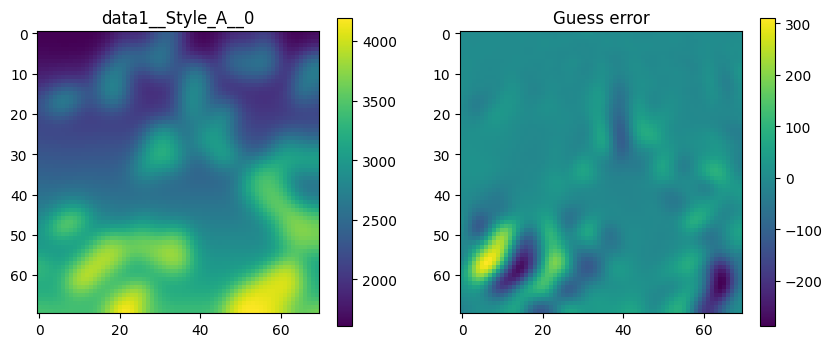

(4901, 1073)
capturing graph
7.721447594539747e-05 54.678996510768926
2.464444277381557 616.7317814293447
0.0003325100275754919 54.64052768618115
7.253637497680843e-05 54.671818483106485
7.252095559062202e-05 54.671902433778335
7.245950148006856e-05 54.67224057632239
7.221726011080084e-05 54.6736305829759
7.130550378168047e-05 54.67978951005696
6.587991555878827e-05 54.82683162114568
6.496941464368616e-05 54.87381261436911
6.327567619268208e-05 55.07054051482168
6.318205140996539e-05 55.07563932744465
6.294144573019085e-05 55.07915922245529
6.272472862510032e-05 55.07821587484135
6.18982233823853e-05 55.068854949327395
6.061733069865721e-05 55.04709869970192
5.896351694314034e-05 55.01048611902532
5.7986627924010426e-05 54.98973201960523
5.774430084788394e-05 54.98540276477362
5.772277372561245e-05 54.987511726441866
5.771064128161722e-05 54.98942144908125
5.7663015022502705e-05 54.99606557143078
5.754608650823834e-05 55.0115125337452
5.72645155612132e-05 55.048666363230176
5.671079686

In [ ]:
importlib.reload(seis_prior)
importlib.reload(seis_diagnostics)
importlib.reload(seis_invert)
kgs.profiling=False
kgs.debugging_mode = 0
seis_forward2.profiling=False
seis_forward2.reset_profile()

model = seis_invert.InversionModel()
model.state = 1
model.method = 'L-BFGS-B'
model.maxiter = 3000
model.prior = seis_prior.SquaredExponential()
model.prior.transform = True
model.prior.svd_cutoff = 1.

do_which_list = [False,False,True]

def param_func(model,value):
    model.prior.λ = 10**value
    return model
param_values = np.linspace(-11,-11,1)
param_name = "log_prior_λ"


for d in data[8000:8001]:
    seis_diagnostics.do_diagnostics_run(d, model, do_which_list, param_func, param_values, param_name)

In [ ]:
%debug

In [ ]:
seis_forward2.show_profile(1)